In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import datetime
import seaborn as sns
import csv
import geopandas as gpd
import geoplot as gplt

# This site was very useful for doing all the things! 
# "Useful Pandas Snippets" by Github user bsweger: https://gist.github.com/bsweger/e5817488d161f37dcbd2

In [2]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [3]:
# Import the snow water equivalent data and station information
# This was downloaded from https://wcc.sc.egov.usda.gov/reportGenerator/
df = pd.read_csv('SNOTEL_download.csv')
stations = pd.read_csv('SNOTEL_stations.csv')

In [4]:
# Rename columns
stations = stations.rename(columns = {
    'Station Id':'StationID'
})

In [5]:
# Remove station names and switch column headers to station ID
df = df.rename(columns={col: col.split(')')[0] for col in df.columns})
df = df.rename(columns={col: col.split('(')[-1] for col in df.columns})

In [6]:
# Select just the years we want
df1 = df.loc[[47, 57, 67, 77,80]]

In [7]:
# Transpose so that the station IDs are now a column
df1 = df1.transpose().rename_axis('Station', axis=1)

In [8]:
# Drop the Date row
df1 = df1.drop(['Date'])

In [9]:
# Rename the columns to the respective years
df1 = df1.rename(columns = {
    47:'1985',
    57:'1995',
    67:'2005',
    77:'2015',
    80:'2018'
})

In [10]:
# Downloaded as CSVs
df1.to_csv("snowpack-data.csv")
stations.to_csv("stations-data.csv")

In [11]:
# Did the merge (on station ID) in Google Fusion Tables because it wasn't working in pandas, arrgghh!!
# Import the merged file
m = pd.read_csv('merged-data.csv')
# Replace null values with -1, so can easily filter
m = m.fillna(value=-1)

In [12]:
# Function to turn a dataframe into a geodataframe using columns Latitude and Longitude
# Takes in a dataframe and returns a geodataframe
def df_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    df = df.drop(['Longitude', 'Latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

In [13]:
#Function to slice a dataframe based on a year
# Takes in a dataframe and a year (as a string), returns a dataframe
# Based on this solution for turning lat and lon pairs into geometries from: https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe
def select_year(df, year):
    df = df[[year,'Station Name','Elevation','geometry']]
    df = df.rename(columns = {
    year:'snowwaterequiv'
})
    return df

In [14]:
# Make a new dataframe with just the stations that have no data
def null_stations(df):
    df = df[df.snowwaterequiv.isin([-1])]
    return df

In [15]:
# Make a new dataframe with just the stations that have data
def stations_with_data(df):
    df = df[~df.snowwaterequiv.isin([-1])]
    return df

In [17]:
# Visualization is based on this tutorial/example: https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorials/Quickstart.ipynb
# To import the sample data: https://github.com/ResidentMario/geoplot/issues/41
import quilt
quilt.install("ResidentMario/geoplot_data")

from quilt.data.ResidentMario import geoplot_data

ResidentMario/geoplot_data already installed.
Overwrite? (y/n) y
All fragments are already downloaded!


In [18]:
# Read in state outlines
contiguous_usa = gpd.read_file(geoplot_data.contiguous_usa())

In [51]:
# Select just the Western states
western_states = contiguous_usa[contiguous_usa.State.isin(['Washington','Oregon','California','Idaho','Nevada','Arizona','Montana','New Mexico','Colorado','Wyoming','Utah'])]

In [19]:
import geoplot.crs as gcrs

In [20]:
# Creates a sub-dataframe based on the range you want
# Takes in a data frame as an input, column to filter on (as a string), also low and high (integers) as inputs
# Returns a new data frame
def filter_range(df,filter_on,low,high):
    df = df[(df[filter_on] > low) & (df[filter_on] <= high)]
    return df

In [44]:
def make_figure_range(df,year,low,high):
    proj = gcrs.AlbersEqualArea()
    # proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)
    
    text_range = str(low) + '-' + str(high)
    # Make a dictionary with the color mapping key
    # Colors based on Color Brewer: http://colorbrewer2.org/#type=diverging&scheme=PuOr&n=5
    #colors = {'0-40':'#e66101', '40-80':'#fdb863', '80-120':'#acacac', '120-160':'#b2abd2', '160-300':'#5e3c99'}
    colors = {'0-40':'#a6611a', '40-80':'#dfc27d', '80-120':'#acacac', '120-160':'#80cdc1', '160-300':'#018571'}
    
    # Exclude nulls
    df1 = stations_with_data(df)
    
    # matplotlib color maps are here: https://matplotlib.org/examples/color/colormaps_reference.html
    ax = gplt.polyplot(western_states, projection=proj, edgecolor="grey", linewidth=0.5, figsize=(10, 12))
    # plot all stations (excluding nulls) as white with a black outline
    gplt.pointplot(df1, ax=ax, projection=proj, color='white', edgecolor='black', linewidth=0.25, s=20)

    # First make a sub-data frame with the range you want
    df2 = filter_range(df1,'snowwaterequiv',low,high)
    if not df2.empty:
        # plot the data stations
        gplt.pointplot(df2, color=colors[text_range], s=45, linewidth=0.25, edgecolor='white', ax=ax, projection=proj)
    
    # Save it with uniquely identifiable file name
    plt.savefig(year + '_' + text_range + '.png')

In [45]:
# This is the main function for generating a 5x5 grid of images
# It looks through all the years and all the relative snowpack ranges and saves each image with a unique filename
def make_all_years_all_ranges():
    gdf = df_to_gdf(m)

    years = ['1985','1995','2005','2015','2018']
    lower_range = [0,40,80,120]

    for year in years:
        df1 = select_year(gdf, year)
        for l in lower_range:
            make_figure_range(df1,year,l,l+40)
        make_figure_range(df1, year, 160, 300)
    

/anaconda/envs/SNOTEL/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


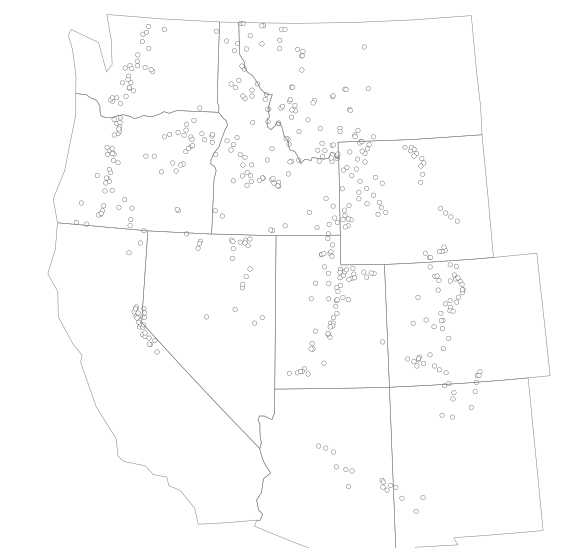

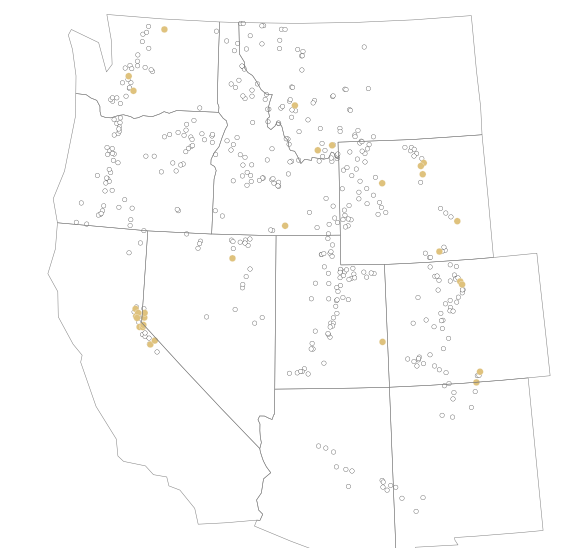

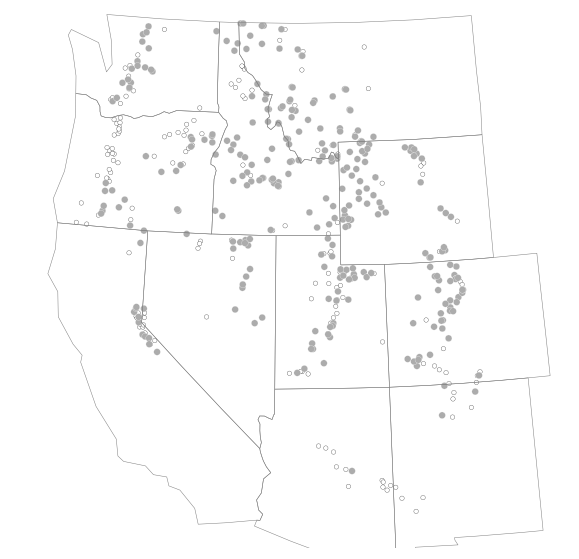

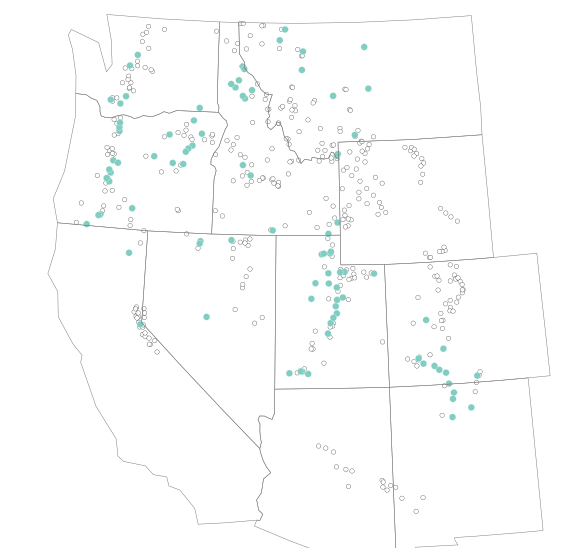

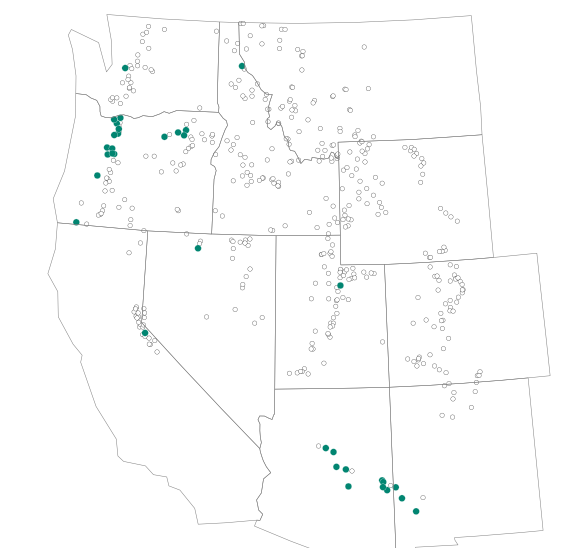

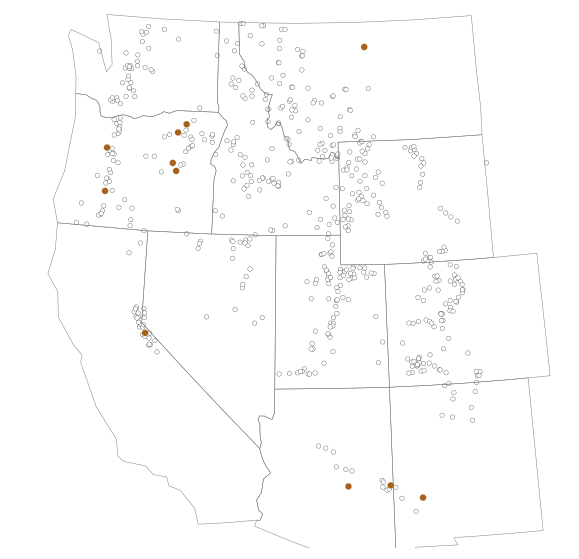

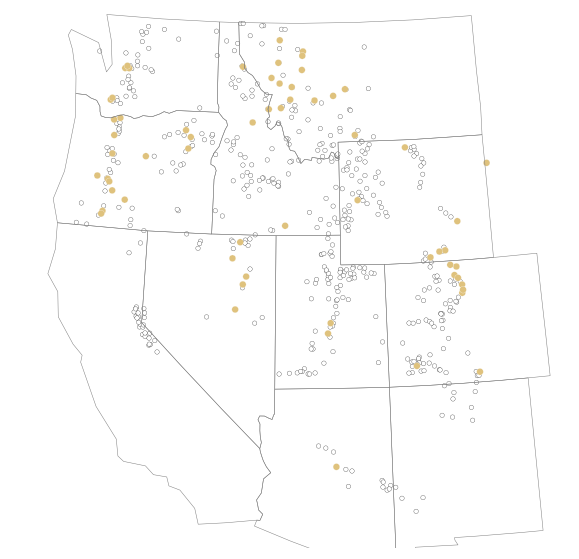

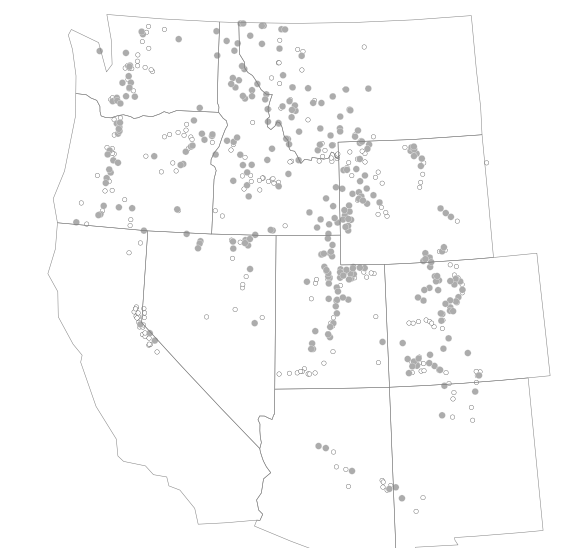

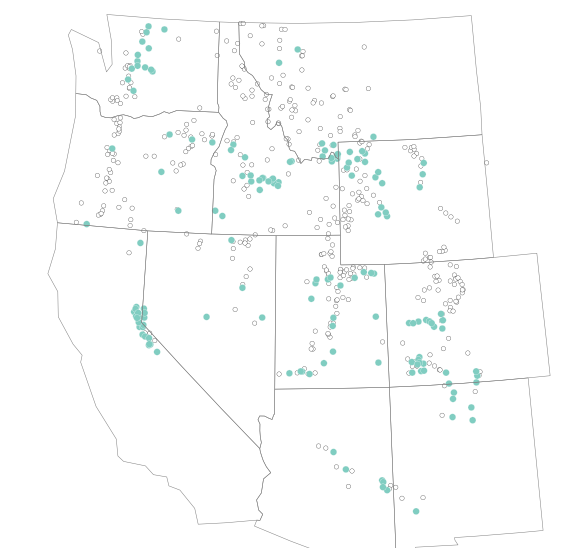

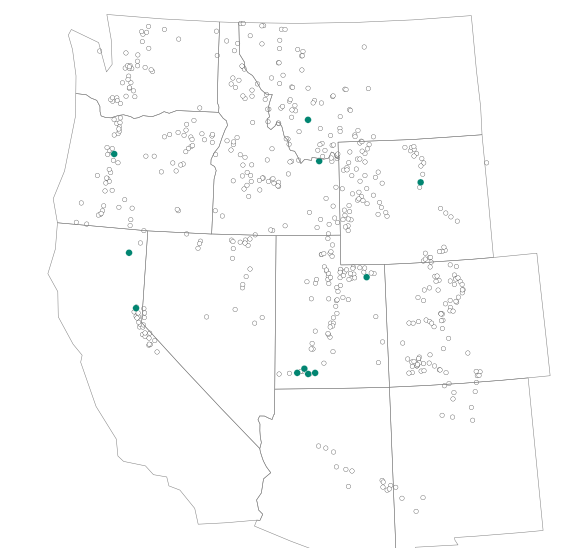

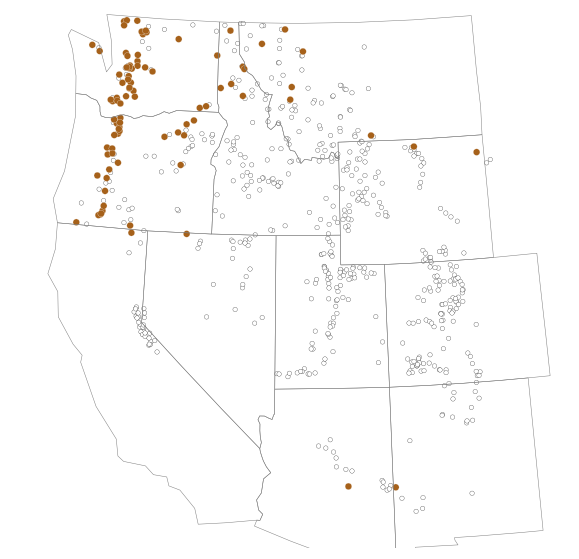

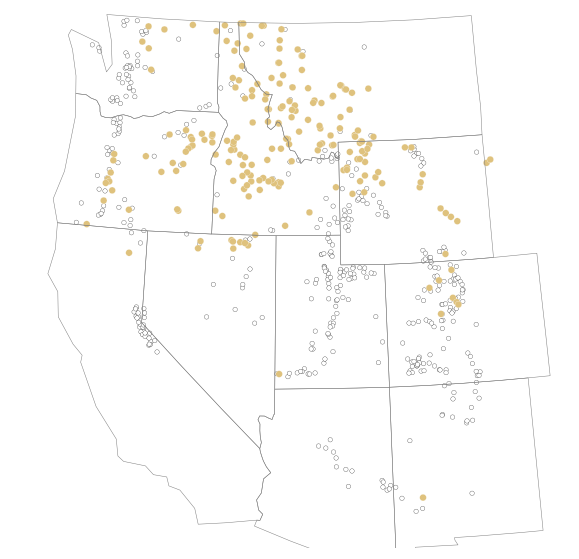

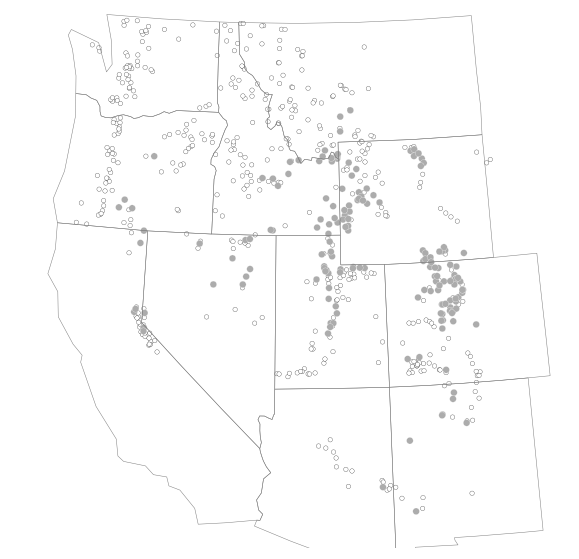

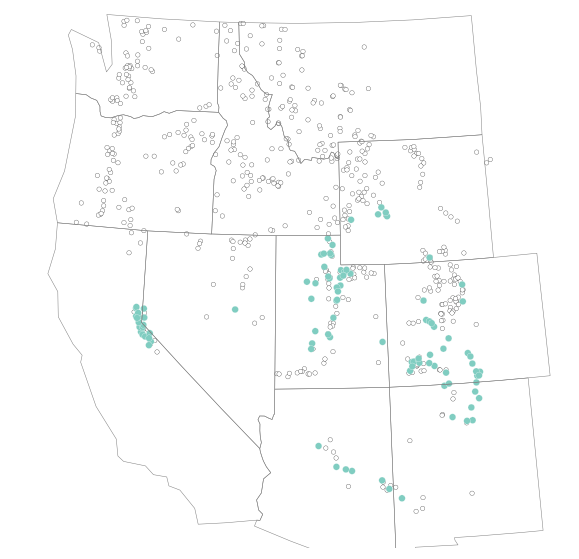

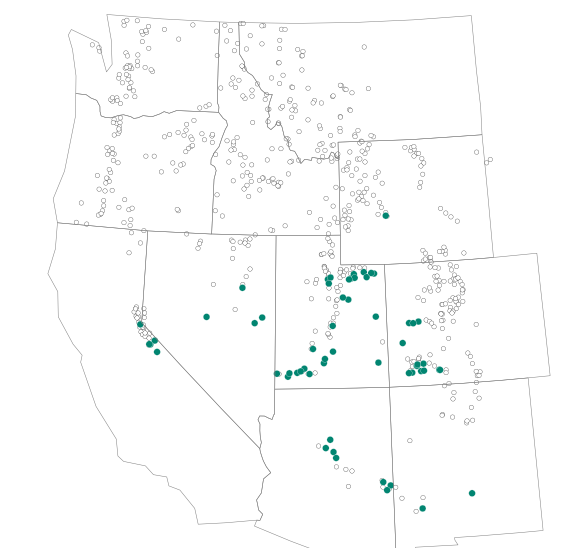

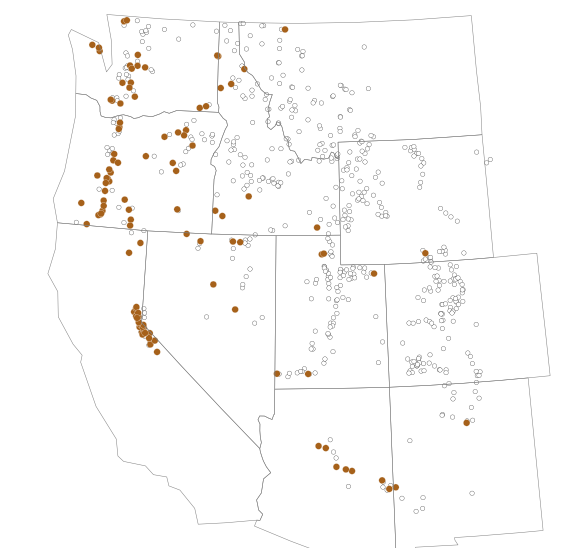

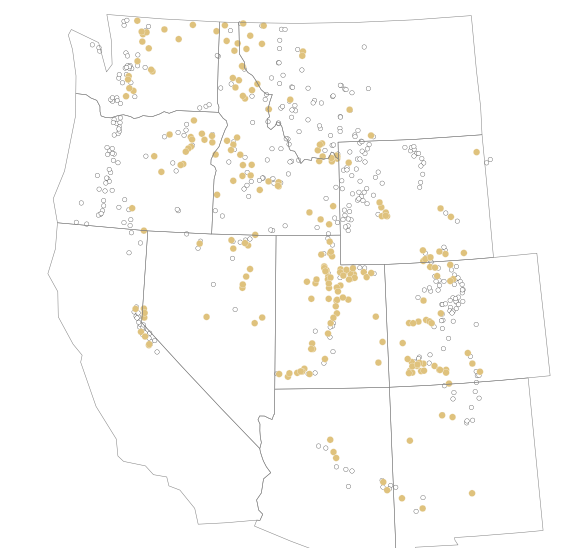

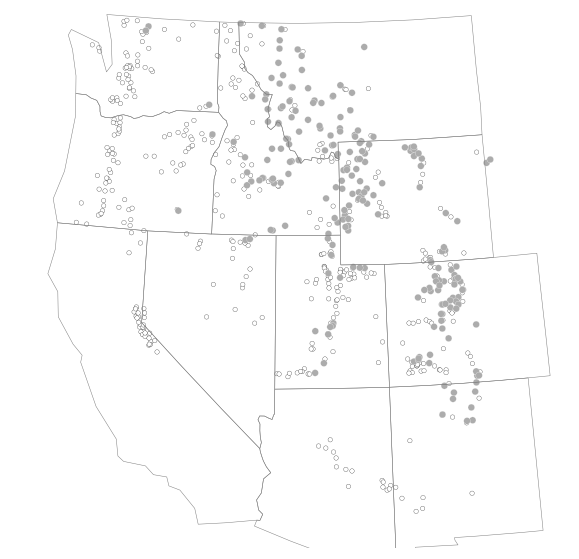

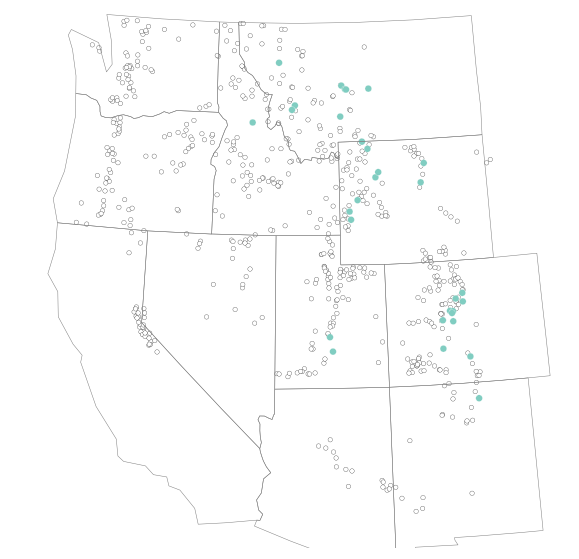

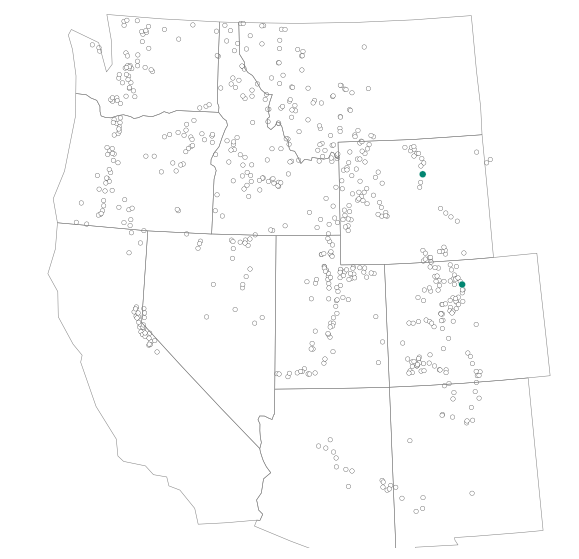

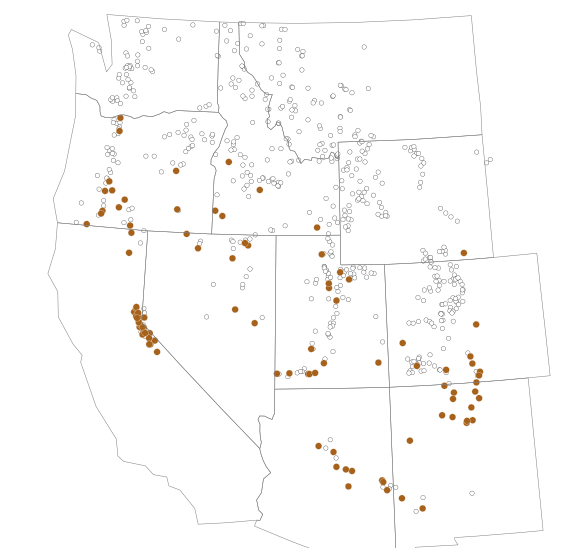

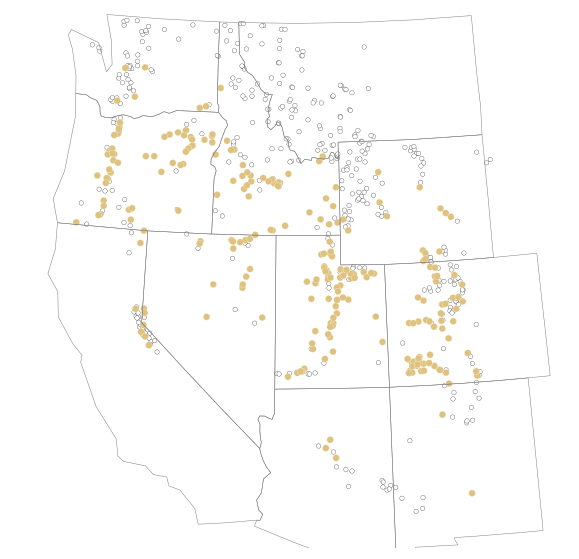

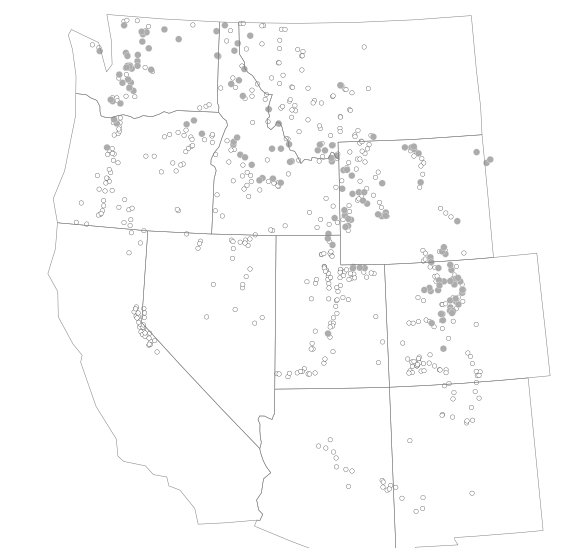

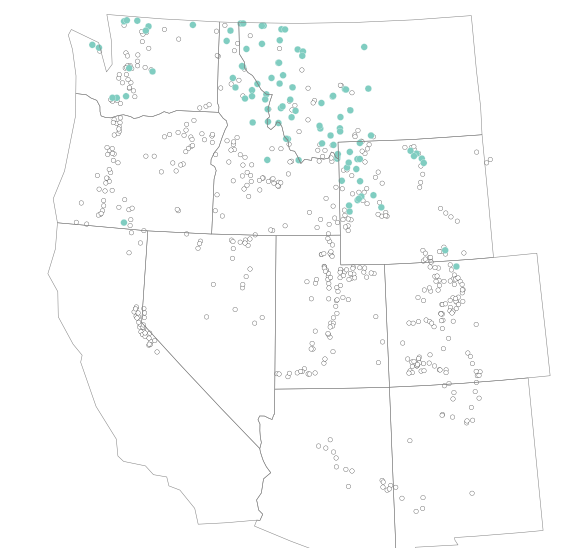

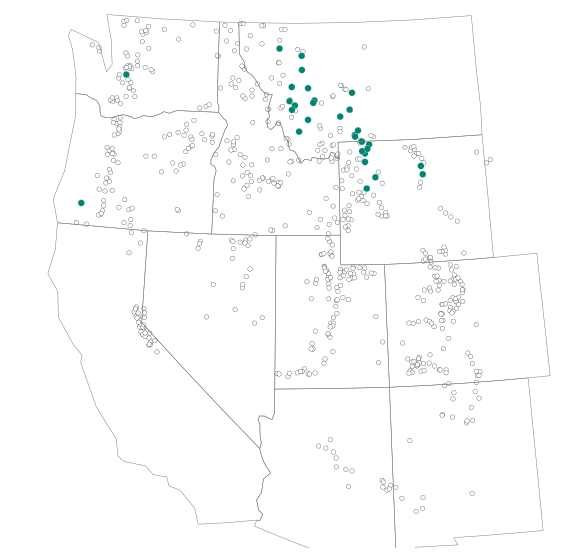

In [46]:
make_all_years_all_ranges()

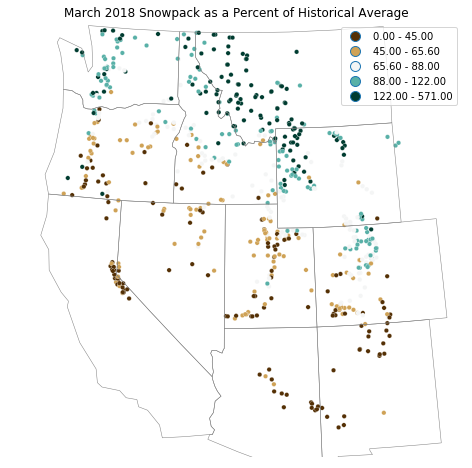

In [60]:
# Make a map that has all the snow water equivalent ranges for 2018
gdf = df_to_gdf(m)
gdf18 = select_year(gdf, '2018')
gdf_nulls = null_stations(gdf18)
gdf_data = stations_with_data(gdf18)

proj = gcrs.AlbersEqualArea()
# proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

# matplotlib color maps are here: https://matplotlib.org/examples/color/colormaps_reference.html
ax = gplt.polyplot(western_states, projection=proj, edgecolor="grey", linewidth=0.5, figsize=(10, 8))

# plot the data stations with a burnt orange/teal color ramp
gplt.pointplot(gdf_data, 
               hue='snowwaterequiv', 
               scheme="Quantiles",
               cmap='BrBG', 
               k=5,  
               linewidth=0.25,  
               edgecolor='white',  
               ax=ax, projection=proj,
              legend=True,
                    legend_kwargs={'loc': 'upper right'},
                    legend_var='hue')

plt.title("March 2018 Snowpack as a Percent of Historical Average")

plt.savefig('foo.png')